In [19]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

class CachedSelectKBestMI(SelectKBest):
    def __init__(self, k, scores, score_func=mutual_info_classif):
        super().__init__(k=k, score_func=score_func)
        self.scores_ = scores
        self.scores = scores

    def fit(self, X, y):
        self._check_params(X, y)
        mask = np.zeros(len(self.scores_), dtype=bool)
        top_k_indices = np.argsort(self.scores_)[::-1][:self.k]
        mask[top_k_indices] = True
        self._mask = mask

        return self

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.0):
        self.threshold = threshold
        self.selected_features_ = None
        self.scores_ = None
        self.mask_ = None

    def fit(self, X, y=None):
        corr_matrix = np.abs(np.corrcoef(X, rowvar=False))
        self.scores_ = corr_matrix
        self.selected_features_ = np.arange(X.shape[1])
        keep_features = []
        for i in range(X.shape[1]):
            if i in self.selected_features_:
                keep_features.append(i)
                correlated_features = np.where(corr_matrix[i] > self.threshold)[0]
                self.selected_features_ = np.setdiff1d(self.selected_features_, correlated_features)
        self.selected_features_ = np.array(keep_features)
        mask = np.zeros(X.shape[1], dtype=bool)
        mask[self.selected_features_] = True
        self.mask_ = mask
        return self

    def transform(self, X):
        return X[:, self.selected_features_]

    def get_support(self):
        return self.mask_

In [1]:
import pandas as pd

train_data = pd.read_csv('../data/train.csv')

X_train, y_train = train_data.drop('Class', axis=1), train_data['Class']
X_train.shape, y_train.shape

((14409, 2400), (14409,))

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

vt = VarianceThreshold(threshold=0.1)
X_vt = vt.fit_transform(X_scaled)

mi = SelectKBest(score_func=mutual_info_classif, k=300)
mi.fit_transform(X_vt, y_train)
mi.scores_

array([0.03900862, 0.02403292, 0.31231443, ..., 0.24557222, 0.08479586,
       0.10673629])

In [11]:
np.save('../output/mutual_info.npy', mi.scores_)

In [287]:
import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import randint, uniform, loguniform

train_data = pd.read_csv('../data/train.csv')
valid_data = pd.read_csv('../data/valid.csv')
test_data = pd.read_csv('../data/test.csv')

X_train = train_data.drop('Class', axis=1)
y_train = train_data['Class']
X_valid = valid_data.drop('Class', axis=1)
y_valid = valid_data['Class']
X_test = test_data.drop('Class', axis=1)
y_test = test_data['Class']

# Combine train and validation sets for RandomizedSearchCV
X_combined = pd.concat([X_train, X_valid], axis=0)
y_combined = pd.concat([y_train, y_valid], axis=0)

# -1 for training samples, 0 for validation samples
split_index = [-1] * len(X_train) + [0] * len(X_valid)
cv = PredefinedSplit(test_fold=split_index)

# load mutual information scores
mi_scores = np.load('../output/mutual_info.npy')

# load pre-trained model
best_model = joblib.load('../output/models/decision_tree.pkl')
best_model = best_model.named_steps['clf']
best_model

DecisionTreeClassifier(max_depth=20, max_features=0.3, min_samples_leaf=5,
                       min_samples_split=14)

In [295]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('vt', VarianceThreshold(threshold=0.1)),
    ('mi', CachedSelectKBestMI(scores=mi_scores, k=100)),
    ('ct', CorrelationThreshold(threshold=1.0)),
    ('clf', BaggingClassifier(estimator=best_model, random_state=42)),
])

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr'),
}

param_distributions = {
    'mi__k': list(range(100, 2500, 100)),
    'ct__threshold': [0.8, 0.7, 0.6, 0.5],
    'clf__n_estimators': [10, 20, 30, 40, 50],
    'clf__max_samples': uniform(0.5, 0.5),
    'clf__max_features': uniform(0.5, 0.5),
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=cv,
    scoring=scoring,
    refit='f1',
    n_jobs=-1,
    verbose=4,
    random_state=42,
)

# Fit on combined data using the predefined split
random_search.fit(X_combined, y_combined)

# Print best parameters and validation scores
print("Best parameters:", random_search.best_params_)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters: {'clf__bootstrap': False, 'clf__bootstrap_features': True, 'clf__max_features': np.float64(0.5499874579090014), 'clf__max_samples': np.float64(0.7296244459829335), 'clf__n_estimators': 50, 'ct__threshold': 0.5, 'mi__k': 800}


In [296]:
cv_results = pd.DataFrame(random_search.cv_results_)
results = cv_results[[
    'param_mi__k', 'param_ct__threshold',
    'param_clf__n_estimators', 'param_clf__max_samples', 'param_clf__max_features',
    'param_clf__bootstrap', 'param_clf__bootstrap_features',
    'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall',
    'mean_test_f1', 'mean_test_roc_auc',
    'rank_test_f1', 'rank_test_roc_auc', 'rank_test_accuracy',
]].sort_values(by=['mean_test_f1', 'mean_test_accuracy', 'mean_test_roc_auc'], ascending=False)
results

,param_mi__k,param_ct__threshold,param_clf__n_estimators,param_clf__max_samples,param_clf__max_features,param_clf__bootstrap,param_clf__bootstrap_features,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,rank_test_f1,rank_test_roc_auc,rank_test_accuracy
1,800,0.5,50,0.729624,0.549987,False,True,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
2,600,0.7,40,0.984955,0.510292,False,True,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
3,1200,0.7,20,0.808741,0.996106,False,False,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
6,700,0.8,50,0.803772,0.523225,False,True,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
8,800,0.8,40,0.841632,0.620513,False,False,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
11,800,0.8,40,0.798950,0.947414,False,False,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
14,300,0.5,10,0.907731,0.502761,False,False,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
17,1400,0.6,50,0.736107,0.943606,False,False,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1
0,700,0.8,50,0.865997,0.975357,True,False,0.999584,0.999584,0.999584,0.999584,0.999584,9,9,9
4,1600,0.5,40,0.699930,0.762387,True,True,0.999584,0.999584,0.999584,0.999584,0.999584,9,9,9


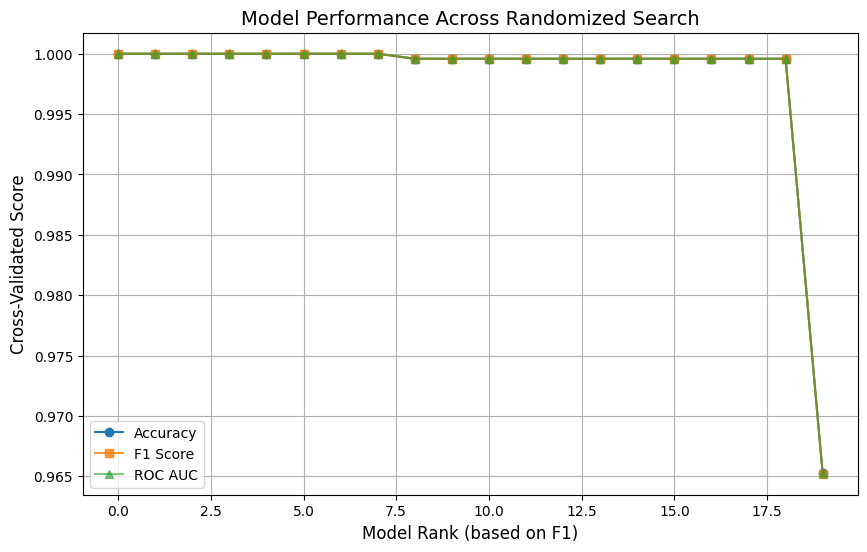

In [297]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot Accuracy, F1, and ROC_AUC
plt.plot(results['mean_test_accuracy'].to_numpy(), label='Accuracy', marker='o', alpha=1.0)
plt.plot(results['mean_test_f1'].to_numpy(), label='F1 Score', marker='s', alpha=0.8)
plt.plot(results['mean_test_roc_auc'].to_numpy(), label='ROC AUC', marker='^', alpha=0.6)

plt.title('Model Performance Across Randomized Search', fontsize=14)
plt.xlabel('Model Rank (based on F1)', fontsize=12)
plt.ylabel('Cross-Validated Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [301]:
# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best params:\n{random_search.best_params_}")

print("\nTest set scores:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.20f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.20f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.20f}")
print(f"F1: {f1_score(y_test, y_pred, average='weighted'):.20f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr'):.20f}")

Best params:
{'clf__bootstrap': False, 'clf__bootstrap_features': True, 'clf__max_features': np.float64(0.5499874579090014), 'clf__max_samples': np.float64(0.7296244459829335), 'clf__n_estimators': 50, 'ct__threshold': 0.5, 'mi__k': 800}

Test set scores:
Accuracy: 1.00000000000000000000
Precision: 1.00000000000000000000
Recall: 1.00000000000000000000
F1: 1.00000000000000000000
ROC-AUC: 1.00000000000000000000


In [299]:
import joblib

joblib.dump(random_search.best_estimator_, '../output/models/bagging_dt.pkl')
# model = joblib.load('best_model.pkl')

['../output/models/bagging_dt.pkl']